In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from pathlib import Path
import torch
import pickle

from modules import optimize_ML
from modules.elbo import ELBO

### Run curvature estimation for 100 different trajectories to test recovery 

In [ ]:
sim_idx = 0 # which out of the 100 simulated trajectories to use
n_traj = 50
n_bootstrap = 20
data_path = Path('data')
c_true = np.zeros((n_traj, n_bootstrap)) # simulated global curvature
c_est = np.zeros((n_traj, n_bootstrap))  # average estimated local curvature

for i in range(n_traj):
    for j in range(n_bootstrap):
        try:
            # load data
            f_name = f'sim_{str(i+1).zfill(4)}.mat'
            S = spio.loadmat(Path(data_path) / f_name)['S']
            S_list = [S[0, i] for i in range(S.shape[1])]  # convert to list of structs
            c_true[i, j] = np.mean(np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten())
            
            # unpack data
            n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
            n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
            n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
            n_dim = 2

            elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=30000, verbose=False)
            x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, _ = elbo.optimize_ELBO_SGD()            
            c_est[i, j] = torch.mean(torch.rad2deg(elbo.mu_post_c)).detach().numpy()
            print(f"Bootstrap: {j}")
        except:
            print(f"Bootstrap run {j} resulted in an error. Will be skipped for the analysis.")

    # save data 
    save_data = {'x_true': S_list[sim_idx]['x'][0, 0],
                 'x_pred': x, # currently only the last most likely trajectory is being saved
                 'perf_true': S_list[sim_idx]['Pc_reshaped'][0, 0],
                 'perf_pred': p.detach().squeeze(),
                 'c_true_sim': np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 
                 'c_post': c_est[i],
                 'c_true': c_true[i]}

    f_name = Path('data') / 'curvatures' / f'curvature_{str(i+1).zfill(4)}.pkl'
    with open(f_name, 'wb') as f:
        pickle.dump(save_data, f)

    if not i % 10:
        print(f"Trajectory: {i}")

Bootstrap: 0
Bootstrap run 1 resulted in an error. Will be skipped for the analysis.
Bootstrap: 2
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap run 9 resulted in an error. Will be skipped for the analysis.
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap: 13
Bootstrap: 14
Bootstrap: 15
Bootstrap: 16
Bootstrap: 17
Bootstrap: 18
Bootstrap: 19
Trajectory: 0
Bootstrap: 0
Bootstrap: 1
Bootstrap: 2
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap: 9
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap: 13
Bootstrap: 14
Bootstrap: 15
Bootstrap: 16
Bootstrap: 17
Bootstrap: 18
Bootstrap: 19
Bootstrap: 0
Bootstrap run 1 resulted in an error. Will be skipped for the analysis.
Bootstrap run 2 resulted in an error. Will be skipped for the analysis.
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap: 9
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap run 13 resulted in an error.

### Visualization

In [3]:
with open(f_name, 'rb') as f:
    loaded_dict = pickle.load(f)

print(loaded_dict.keys())

dict_keys(['x_true', 'x_pred', 'perf_true', 'perf_pred', 'c_true_sim', 'c_post', 'c_true'])


In [11]:
loaded_dict['c_post'][6]

array([105.37726662,  80.97433404,  70.79645633,  93.13398216,
        70.15796028,  86.34139705,  79.0299111 ,  86.00267941,
        85.70351317,  74.56528907,  91.14260726,  98.81525837,
         0.        ,  87.0555177 ,  67.65573335,  80.59810726,
        62.98943439,  90.74235558,  75.97793759,  80.45186135])

/opt/anaconda3/envs/vision/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


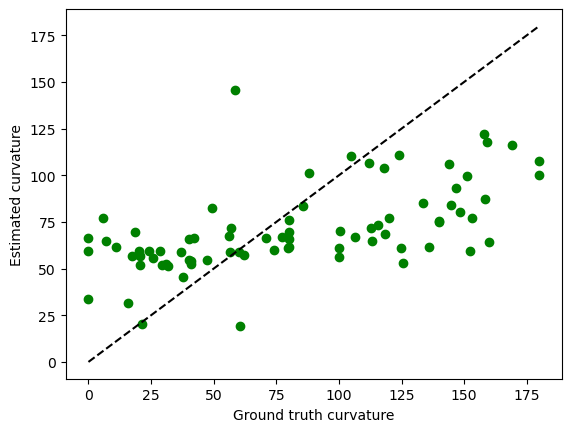

In [ ]:
plt.plot(c_true, c_est, 'go')
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Ground truth curvature')
plt.ylabel('Estimated curvature')
plt.show()